In [1]:
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt
%matplotlib widget

In [2]:
def controller(img, brightness=255,
               contrast=127):
    
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
  
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
  
    if brightness != 0:
  
        if brightness > 0:
  
            shadow = brightness
  
            max = 255
  
        else:
  
            shadow = 0
            max = 255 + brightness
  
        al_pha = (max - shadow) / 255
        ga_mma = shadow
  
        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(img, al_pha, 
                              img, 0, ga_mma)
  
    else:
        cal = img
  
    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)
  
        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(cal, Alpha, 
                              cal, 0, Gamma)
  
    # putText renders the specified text string in the image.
    cv2.putText(cal, 'B:{},C:{}'.format(brightness,
                                        contrast), (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
  
    return cal

In [3]:
def get_linear_max_1(p1, p2, max_coord): 
    x1, y1 = p1
    x2, y2 = p2
    xmax, ymax = max_coord
    
    # print("point1", p1, "point2", p2, "max_values", max_coord)
    
    a = (y1 - y2) / (x1 - x2)
    b = -(a*x1) + y1

    # print("a", a, "b", b)

    ox1 = (ymax-b) / a
    oy1 = a * xmax + b
    
    # print("ox1", ox1, "oy1", oy1)
    
    if ox1 >= xmax:
        return max(0,int(xmax)), max(0,int(oy1))
    else:
        return max(0,int(ox1)), max(0, int(ymax))
def get_linear_max_2(p1, p2, max_coord): 
    x1, y1 = p1
    x2, y2 = p2
    xmax, ymax = max_coord
    
    # print("point1", p1, "point2", p2, "max_values", max_coord)
    # 
    a = (y1 - y2) / (x1 - x2)
    b = -(a*x1) + y1

    # print("a", a, "b", b)

    ox1 = (ymax-b) / a
    oy1 = a * xmax + b
    
    # print("ox1", ox1, "oy1", oy1)
    
    if ox1 >= xmax:
        return max(0,int(xmax)), max(0,int(oy1))
    else:
        return max(0,int(ox1)), max(0, int(ymax))


# print(get_linear_max((4,1), (2,3), (20, 40)))

In [4]:
def stretch_image(image, new_width, new_height):
    # Get the current dimensions of the image
    height, width = image.shape[:2]

    # Calculate the scaling factors for width and height
    width_ratio = new_width / width
    height_ratio = new_height / height

    # Apply the scaling factors to resize the image
    resized_image = cv2.resize(image, (new_width, new_height))

    return resized_image



[INFO] loading image...
<class 'cv2.aruco.Dictionary'> <class 'cv2.aruco.DetectorParameters'>


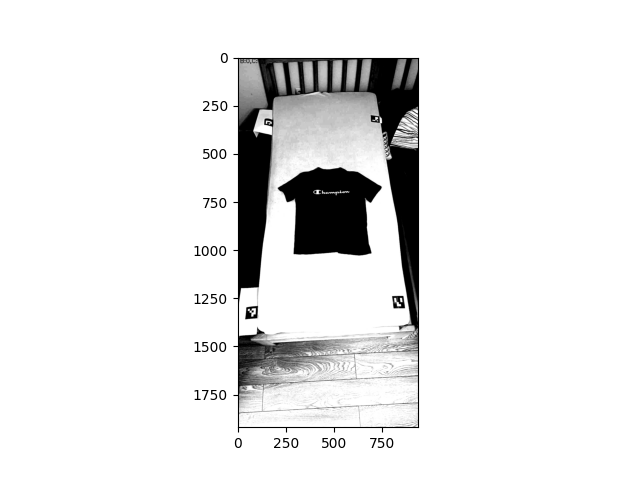

[[0]
 [3]
 [1]
 [2]]


In [5]:
print("[INFO] loading image...")
image = cv2.imread("./a.jpg")
arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
arucoParams =  cv2.aruco.DetectorParameters()
print(type(arucoDict), type(arucoParams))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_aruco_out = controller(gray, contrast=200, brightness=255)
plt.imshow(cv2.cvtColor(_aruco_out, cv2.COLOR_GRAY2RGB))
plt.show()
(corners, ids, rejected) = cv2.aruco.detectMarkers(_aruco_out, arucoDict,
	parameters=arucoParams)
print(ids)

In [6]:
ids = ids.flatten()
imgxy = image.shape[1], image.shape[0]
points = {}
markers = dict(zip(ids, corners))
for _id, coords in markers.items():
    corners = coords.reshape((4, 2))
    if _id in [0,3]:
        point = corners[1]
    else:
        point = corners[2]
    points[_id] = [int(i) for i in point]


In [7]:

tl = points[1]
tr = points[2]
bl = points[0]
br = points[3]
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

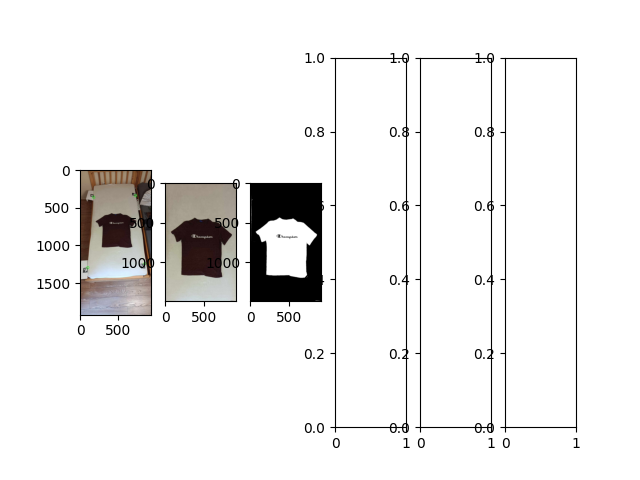

In [8]:
M = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), np.float32(destination_corners))

fig, (ax, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)

warped_image = cv2.warpPerspective(image, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)

dest_w, dest_h = (900, 1500)
aspect_corrected = stretch_image(warped_image, dest_w, dest_h)  

image = cv2.circle(image, points[0], 16, (0,255,0), 4)
image = cv2.circle(image, points[1], 16, (0,255,0), 4)
image = cv2.circle(image, points[2], 16, (0,255,0), 4)
image = cv2.circle(image, points[3], 16, (0,255,0), 4)
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

ax2.imshow(cv2.cvtColor(aspect_corrected, cv2.COLOR_BGR2RGB))

thresh = cv2.threshold(cv2.cvtColor(aspect_corrected, cv2.COLOR_BGR2GRAY), 140, 255, cv2.THRESH_BINARY_INV)[1]

ax3.imshow(cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB))
plt.show()


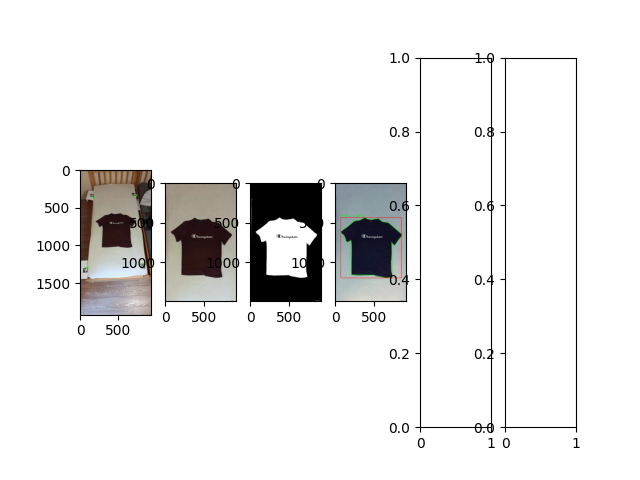

In [9]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
eps = 0.005

peri = cv2.arcLength(c, True)
approx = cv2.approxPolyDP(c, eps * peri, True)

output = aspect_corrected.copy()
show_box = cv2.drawContours(output, [approx], -1, (0, 255, 0), 3)
box = cv2.boundingRect(approx)
(x, y, w, h) = box

show_box = cv2.rectangle(show_box, (x, y), (x + w, y + h), (255,0,0), 4)
text = "original, num_pts={}".format(len(approx))
show_box = cv2.putText(show_box, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX,
	0.9, (0, 255, 0), 2)

ax4.imshow(show_box)
plt.show()


In [10]:
def crop_and_center_image(image, bounding_box):
    x, y, width, height = bounding_box
    # Calculate the aspect ratio of the bounding box
    aspect_ratio = 1

    # Determine the target dimensions for the crop
    target_width = max(width, height)
    target_height = int(target_width)

    # Calculate the top-left corner coordinates of the square crop
    crop_x = x
    crop_y = y

    # Calculate the bottom-right corner coordinates of the square crop
    crop_x2 = crop_x + width
    crop_y2 = crop_y + height

    # Adjust the crop coordinates to ensure they are within the image boundaries
    # crop_x = max(crop_x, 0)
    # crop_y = max(crop_y, 0)
    # crop_x2 = min(crop_x2, image.shape[1])
    # crop_y2 = min(crop_y2, image.shape[0])

    # Crop the image to the target dimensions
    cropped_image = image[crop_y:crop_y2, crop_x:crop_x2]

    # Calculate the position to paste the cropped image on the canvas
    paste_x = max(-(crop_x - x), 0)
    paste_y = max(-(crop_y - y), 0)

    canvas = np.ones((target_height, target_width, 3), dtype=np.uint8) * 255
    # Calculate the position to center the cropped image within the canvas
    center_x = paste_x + cropped_image.shape[1] // 2
    center_y = paste_y + cropped_image.shape[0] // 2
    canvas_center = np.array([canvas.shape[1] // 2, canvas.shape[0] // 2])

    # Calculate the position to paste the cropped image onto the canvas
    paste_position = canvas_center - np.array([center_x, center_y]) + np.array([paste_x, paste_y])

    # Create a black canvas with the target dimensions

    # Paste the cropped image onto the canvas
    canvas[paste_position[1]:paste_position[1] + cropped_image.shape[0],
        paste_position[0]:paste_position[0] + cropped_image.shape[1]] = cropped_image


    return canvas

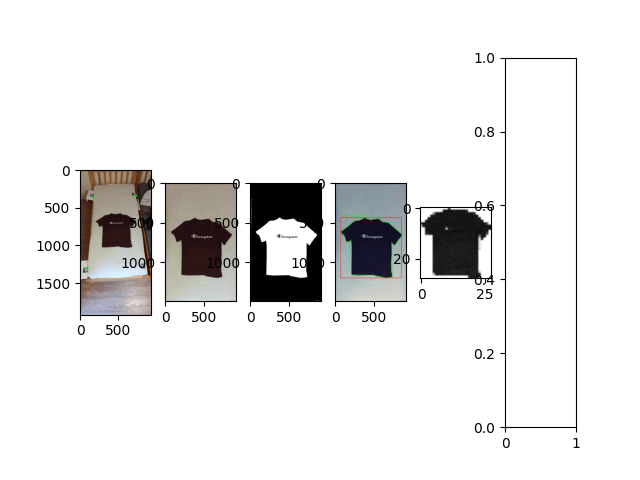

In [11]:
thresh_inv = cv2.bitwise_not(thresh)

img = aspect_corrected.copy()
img[thresh == 0] = (255, 255, 255)
out = cv2.cvtColor(stretch_image(crop_and_center_image(img, box), 28, 28), cv2.COLOR_BGR2GRAY)
ax5.imshow(cv2.cvtColor(out, cv2.COLOR_GRAY2RGB))
plt.show()

In [12]:
import torch
from torch import nn
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(6272, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 10)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 
model = CIFAR10Model()
model.eval()
model.load_state_dict(torch.load("1689517358_checkpoint.pth"))



<All keys matched successfully>

In [13]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        labels = ['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot']
        ax2.set_yticklabels(labels, size='small');
        print("biggest val", labels[ps.tolist().index(max(ps))])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

biggest val T-shirt/top


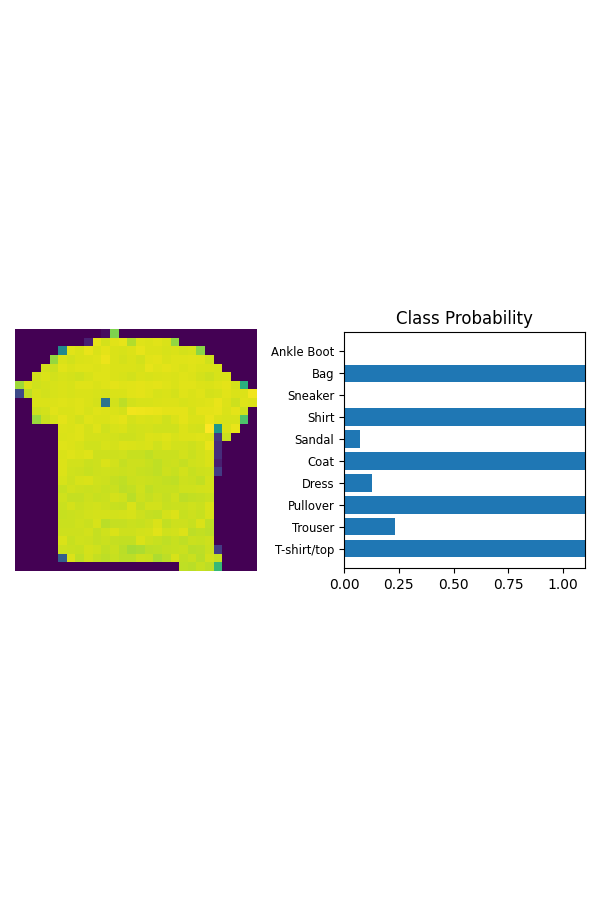

In [14]:
img = cv2.bitwise_not(out).reshape(1, 1, 28, 28).astype('float32') / 255
def scale_range(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    return 2 * (arr - min_val) / (max_val - min_val) - 1
    
img = torch.tensor(scale_range(img))
ps = torch.exp(model(img))
view_classify(img, ps, version='Fashion')